***chapter2 銷售趨勢預測季節性分析***

In [85]:
import pandas as pd
import pymysql
from  sqlalchemy import create_engine
from statsmodels.tsa.seasonal import seasonal_decompose
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np
from pathlib import Path

In [3]:
df = pd.read_excel("/Users/wendychu/Desktop/python/walmart ba project/my_env1/walmart_time.xlsx")

In [4]:
#計算月度銷售額
month_sale=df.groupby(pd.Grouper(key="date",freq="M"))["total"].sum().reset_index()
print(type(month_sale))

<class 'pandas.core.frame.DataFrame'>


/var/folders/ch/3q7p7fzx3w92z4v7n4s0n_500000gn/T/ipykernel_57860/1105655231.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_sale=df.groupby(pd.Grouper(key="date",freq="M"))["total"].sum().reset_index()


In [5]:
df.head()
print(month_sale)

         date     total
0  2019-01-31  82440.54
1  2019-02-28  60161.66
2  2019-03-31  69285.00
3  2019-04-30   7578.69
4  2019-05-31  12189.23
5  2019-06-30   9154.50
6  2019-07-31  10953.06
7  2019-08-31  12860.74
8  2019-09-30  13111.70
9  2019-10-31   9395.43
10 2019-11-30   9160.35
11 2019-12-31  11296.48
12 2020-01-31  14414.00
13 2020-02-29  11044.00
14 2020-03-31  10496.00
15 2020-04-30  10275.00
16 2020-05-31  11107.00
17 2020-06-30   9913.00
18 2020-07-31  12110.00
19 2020-08-31  17936.00
20 2020-09-30  17922.00
21 2020-10-31  18133.00
22 2020-11-30  44917.00
23 2020-12-31  42219.00
24 2021-01-31  17160.00
25 2021-02-28  13369.00
26 2021-03-31  12455.00
27 2021-04-30  10084.00
28 2021-05-31  11299.00
29 2021-06-30  12667.00
30 2021-07-31  10949.00
31 2021-08-31  17040.00
32 2021-09-30  19558.00
33 2021-10-31  18805.00
34 2021-11-30  45218.00
35 2021-12-31  46528.00
36 2022-01-31  14424.00
37 2022-02-28  14208.00
38 2022-03-31  11842.00
39 2022-04-30  10569.00
40 2022-05-31  1

***2.1月份銷售額趨勢***

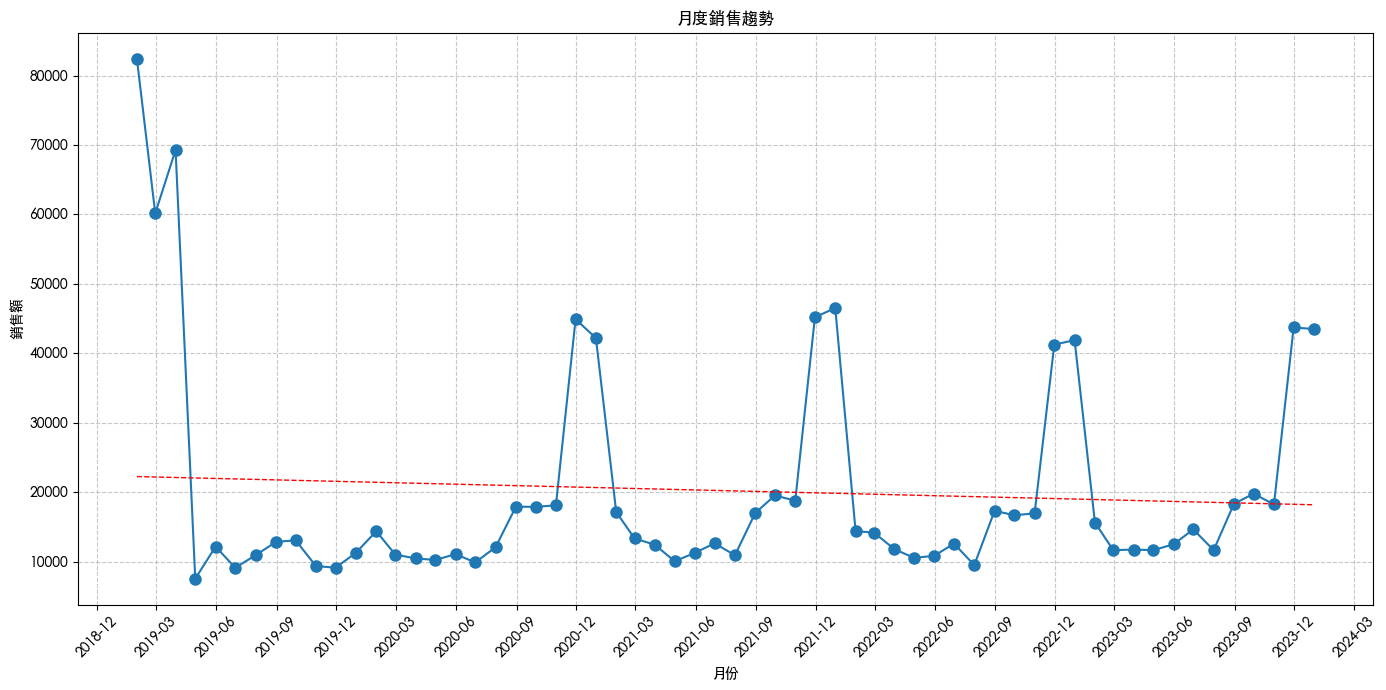

In [6]:

plt.rcParams["font.sans-serif"] = ["Heiti TC"]  # macOS # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False 

plt.figure(figsize=(14,7))
plt.plot(month_sale["date"],month_sale["total"],marker='o',markersize=8)
plt.title("月度銷售趨勢")
plt.xlabel("月份")
plt.ylabel("銷售額")
plt.grid(True, linestyle='--', alpha=0.7)

#標籤設定
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.rcParams["font.sans-serif"] = ["Heiti TC"]  # macOS # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False 

#趨勢線計算
z=np.polyfit(range(len(month_sale)),month_sale["total"],1)
p=np.poly1d(z)
plt.plot(month_sale["date"],p(range(len(month_sale))),"r--", linewidth=1)
plt.tight_layout()
plt.savefig('月份銷售趨勢.png', dpi=300)

***2.2季節性模式分析***

In [7]:
#按年月份重新分組
year_month_sale=df.groupby(["year","month"])["total"].sum().reset_index()
year_month_pivot =year_month_sale.pivot_table(index="month",columns="year",values="total")

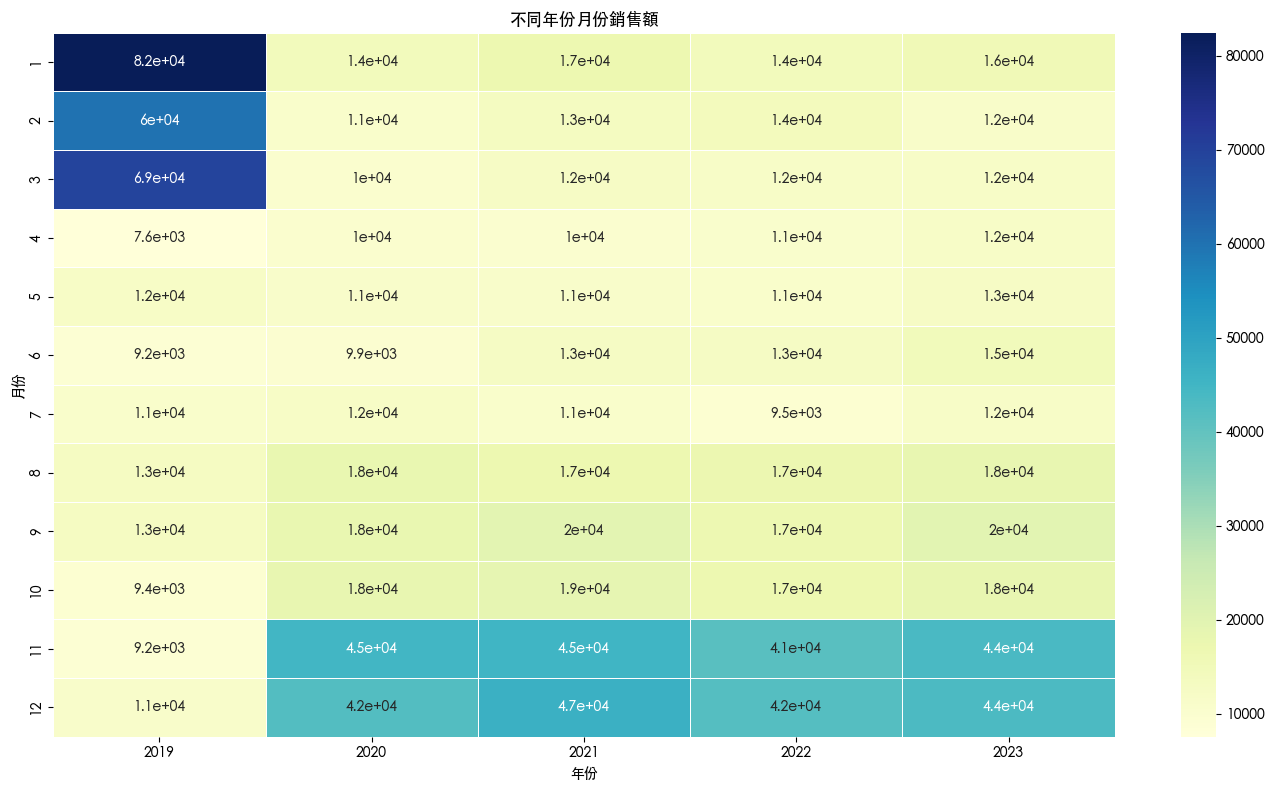

In [ ]:
#圖表化年份月份對比
plt.figure(figsize=(14,8))

#熱力圖來顯示銷售額對比
sns.heatmap(data=year_month_pivot,annot=True,cmap='YlGnBu', linewidths=.5)
plt.title("不同年份月份銷售額")
plt.xlabel("年份")
plt.ylabel("月份")
plt.tight_layout()
plt.savefig("年份月份熱力圖")

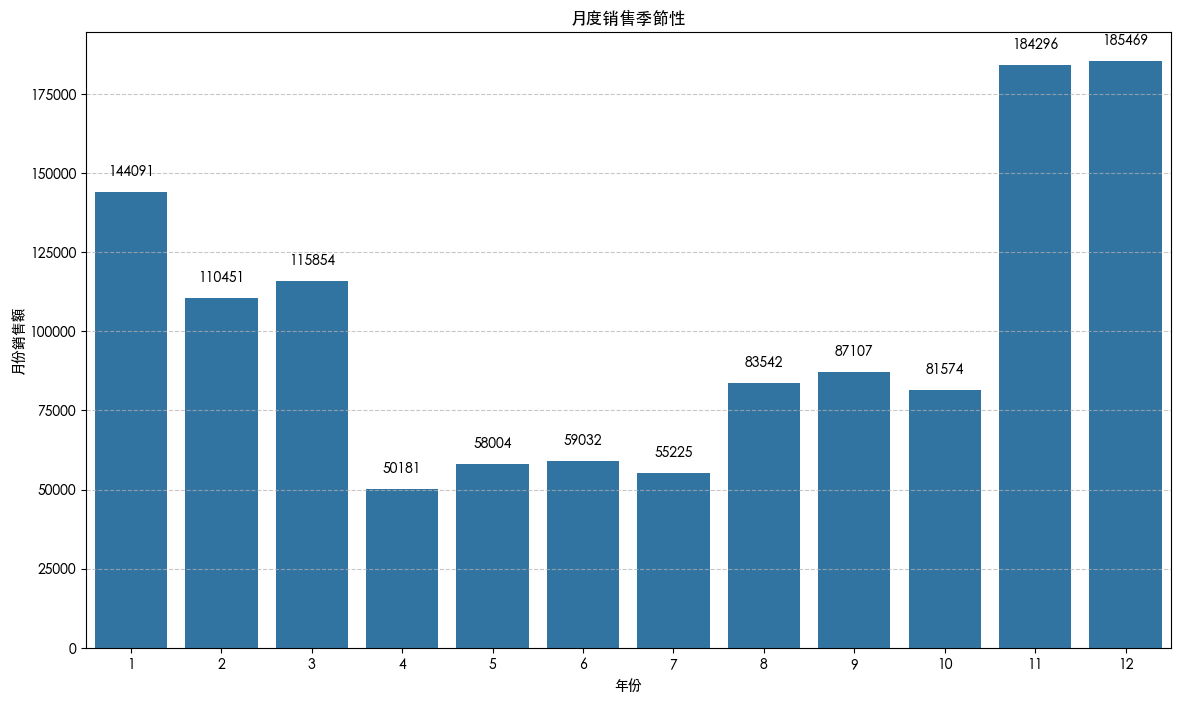

In [94]:
##圖表化月度销售季節性對比（沒有通過年份）
plt.figure(figsize=(14,8))

#計算月份
only_month_sale=df.groupby(["month"])["total"].sum().reset_index()


#圖表製作
sns.barplot(x="month",y="total",data=only_month_sale)
plt.title("月度销售季節性")
plt.xlabel("年份")
plt.ylabel("月份銷售額")
plt.grid(True,axis='y',linestyle='--', alpha=0.7)
#標籤插入
for i ,v in enumerate(only_month_sale["total"]) :
    plt.text(i,v+5000,f"{v:.0f}",ha='center')

plt.tight_layout
plt.savefig('月份季節性分析', dpi=300)



              total
date               
2019-09-03  7118.14
2019-07-02  6884.01
2019-03-14  6871.08
2019-02-15  6505.51
2019-02-03  6247.91


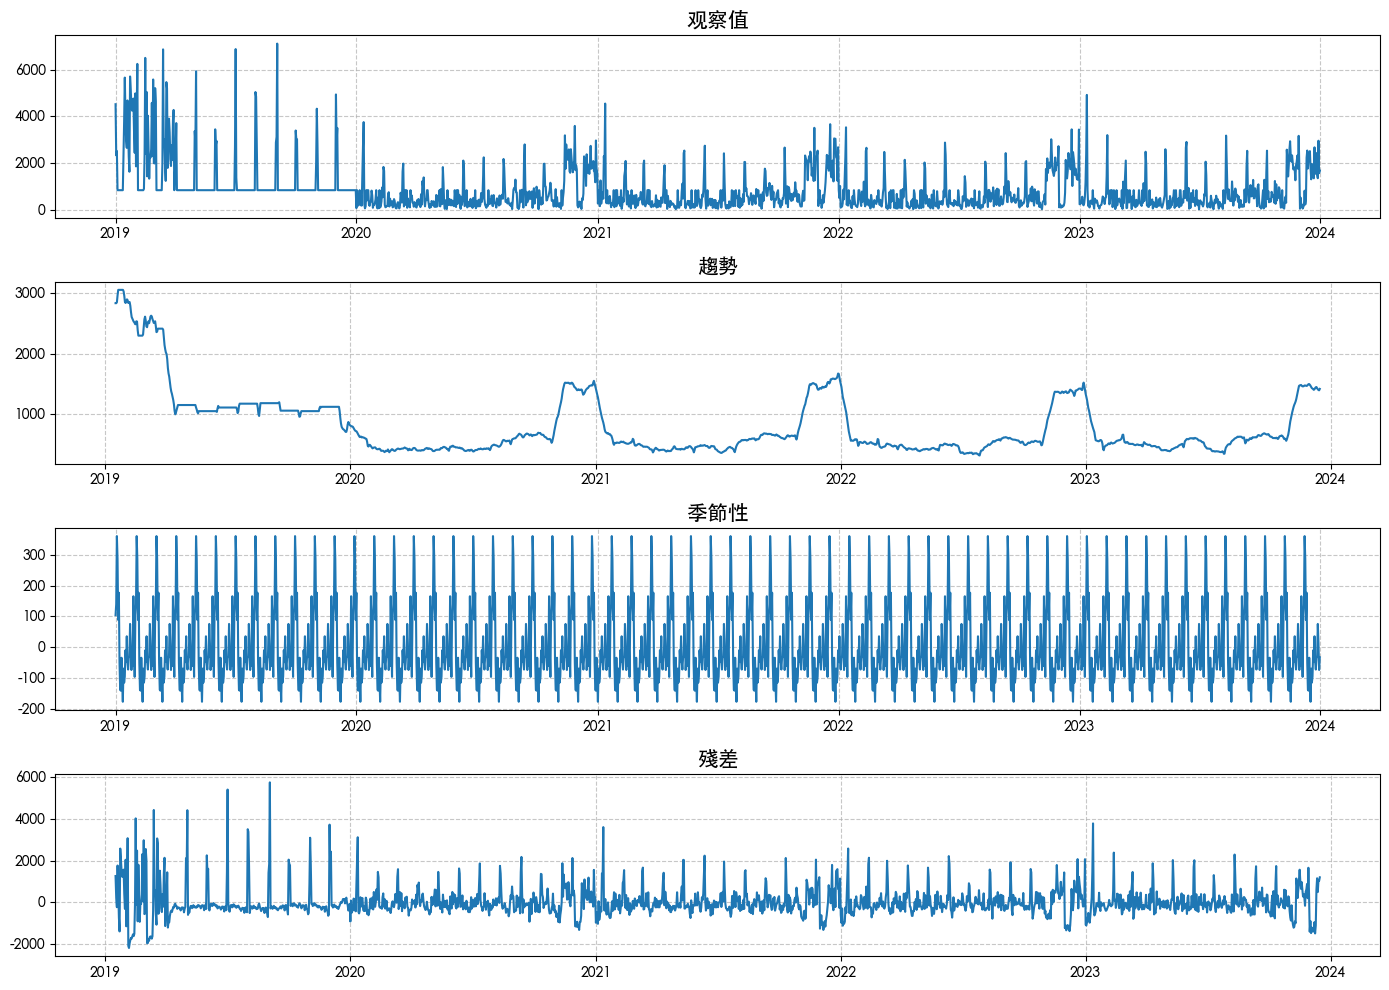

In [23]:
#使用時間序列分析更清楚知道趨勢\季節性

#先計算每日銷售額
daily_sale=df.groupby("date")["total"].sum().reset_index()
daily_sale=daily_sale.sort_values(by="total",ascending=False)
daily_sale.set_index('date', inplace=True)
print(daily_sale.head())


#尋找缺失日期填充值
full_date_sale=pd.date_range(start=daily_sale.index.min(),end=daily_sale.index.max())
daily_sale_filled=daily_sale.reindex(full_date_sale).fillna(daily_sale.mean())

#使用時間序列
decomposition = seasonal_decompose(daily_sale_filled,model="additive",period=30)

#可視化分析解果
plt.figure(figsize=(14,10))

plt.subplot(411)
plt.plot(decomposition.observed)
plt.title('观察值', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(412)
plt.plot(decomposition.trend)
plt.title('趨勢', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.title('季節性', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(414)
plt.plot(decomposition.resid)
plt.title('殘差', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("時間序列分析")

***2.3 周銷售和日銷售分析***




***流量 vs. 销售额：

交易数量最高的日子是否也是销售额最高的日子？
如果不一致，说明客单价存在显著差异


消费行为差异：

工作日和周末的平均交易额是否存在差异？
高交易量日的客单价是否较低（可能是小额购买较多）？


运营优化机会：

高交易量日可能需要更多收银员和客服人员
高客单价日可能需要更专业的销售人员
低销售日可以安排特别促销或会员活动***

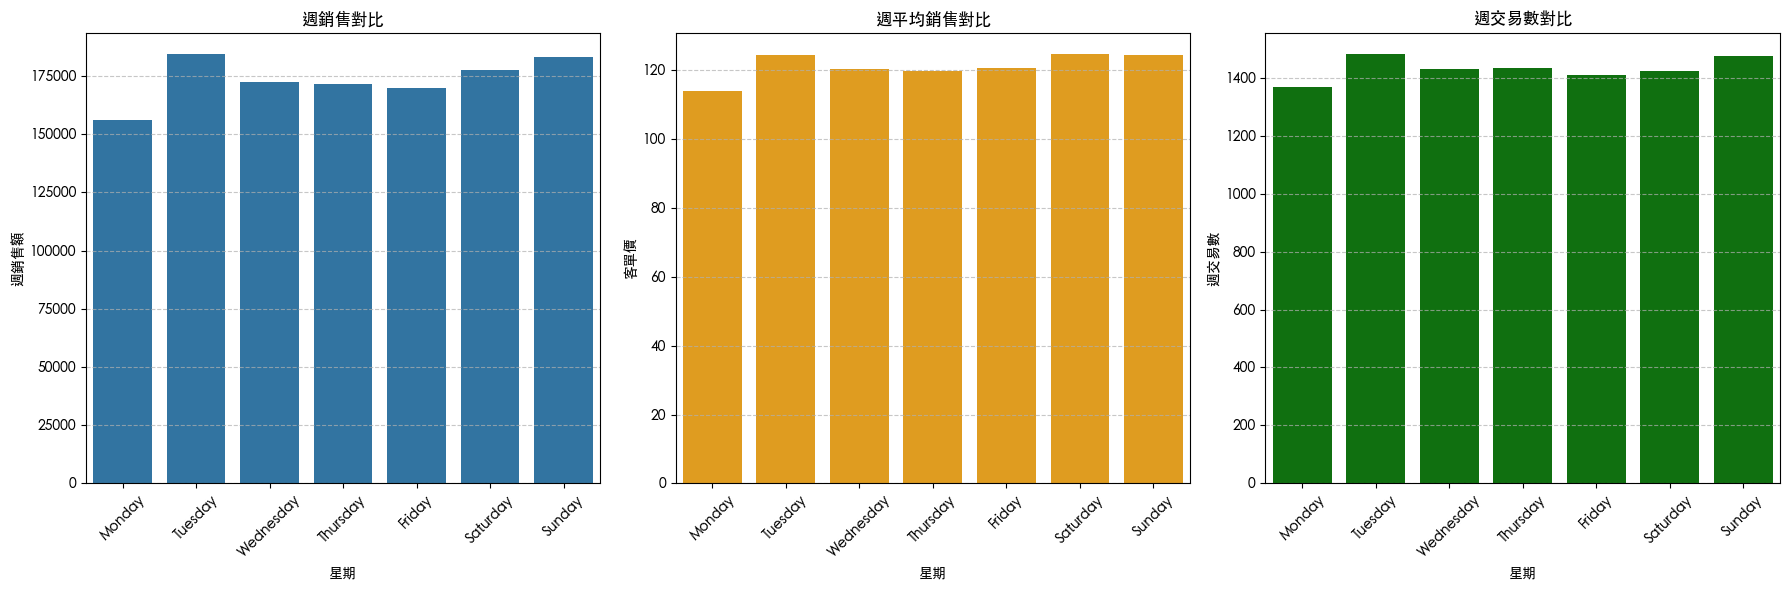

In [20]:
#計算週銷售/周平均銷售/周交易數
weekday_sale=df.groupby(["weekday","weekday_name"])["total"].sum().reset_index()
weekday_avg=df.groupby(["weekday","weekday_name"])["total"].mean().reset_index()
weekday_transc_count=df.groupby(["weekday","weekday_name"]).size().reset_index()

weekday_transc_count.columns=["weekday","weekday_name","transaction_counts"]
weekday_avg.columns=["weekday","weekday_name","avg_sale"]
weekday_sale.columns=["weekday","weekday_name","total_sale"]

#合併數據
weekday_analysis=pd.merge(weekday_sale,weekday_avg,on=['weekday', 'weekday_name'])
weekday_analysis=pd.merge(weekday_analysis,weekday_transc_count,on=['weekday', 'weekday_name'])
weekday_analysis.sort_values('weekday', inplace=True)

#可視化圖表
    #週銷售對比
plt.figure(figsize=(18,6))
plt.subplot(131)
sns.barplot(x="weekday_name",y="total_sale",data=weekday_analysis)
plt.title("週銷售對比")
plt.xlabel("星期")
plt.ylabel("週銷售額")
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    #客單價對比
plt.subplot(132)
sns.barplot(x="weekday_name",y="avg_sale",data=weekday_analysis,color="orange")
plt.title("週平均銷售對比")
plt.xlabel("星期")
plt.ylabel("客單價")
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    #週交易數對比
plt.subplot(133)
sns.barplot(x="weekday_name",y="transaction_counts",data=weekday_analysis,color="green")
plt.title("週交易數對比")
plt.xlabel("星期")
plt.ylabel("週交易數")
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('週銷售分析.png', dpi=300)



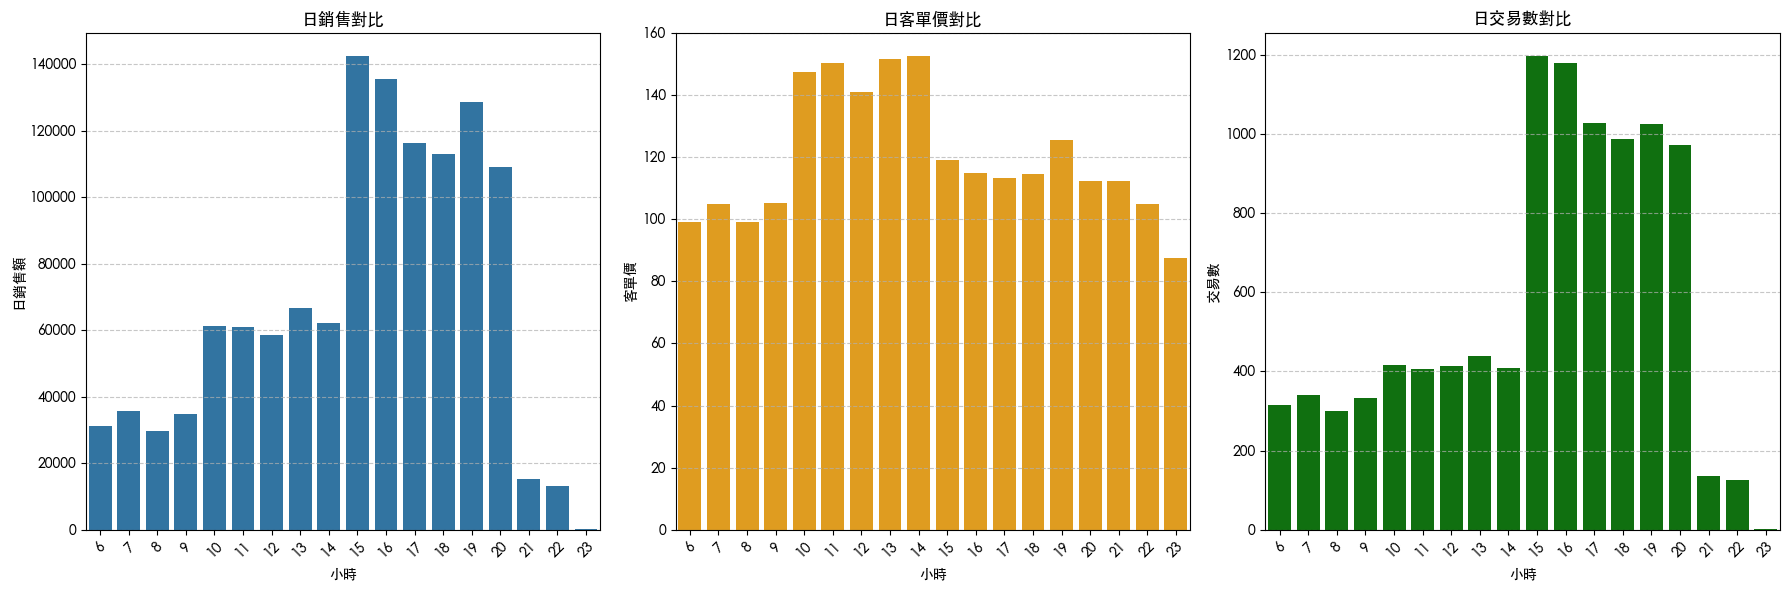

In [12]:
#日銷售額計算_按小時
hour_sale=df.groupby("hour")["total"].sum().reset_index()
hour_count=df.groupby("hour")["total"].size().reset_index()
hour_count.columns=["hour","transcation_count"]
#合併圖表
daily_hour_analysis=pd.merge(hour_sale,hour_count,on=['hour'])
daily_hour_analysis["avg_sale"]=daily_hour_analysis["total"]/daily_hour_analysis["transcation_count"]
#可視化圖表
 #週銷售對比
plt.figure(figsize=(18,6))
plt.subplot(131)
sns.barplot(x="hour",y="total",data=daily_hour_analysis)
plt.title("日銷售對比")
plt.xlabel("小時")
plt.ylabel("日銷售額")
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    #客單價對比
plt.subplot(132)
sns.barplot(x="hour",y="avg_sale",data=daily_hour_analysis,color="orange")
plt.title("日客單價對比")
plt.xlabel("小時")
plt.ylabel("客單價")
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    #週交易數對比
plt.subplot(133)
sns.barplot(x="hour",y="transcation_count",data=daily_hour_analysis,color="green")
plt.title("日交易數對比")
plt.xlabel("小時")
plt.ylabel("交易數")
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()




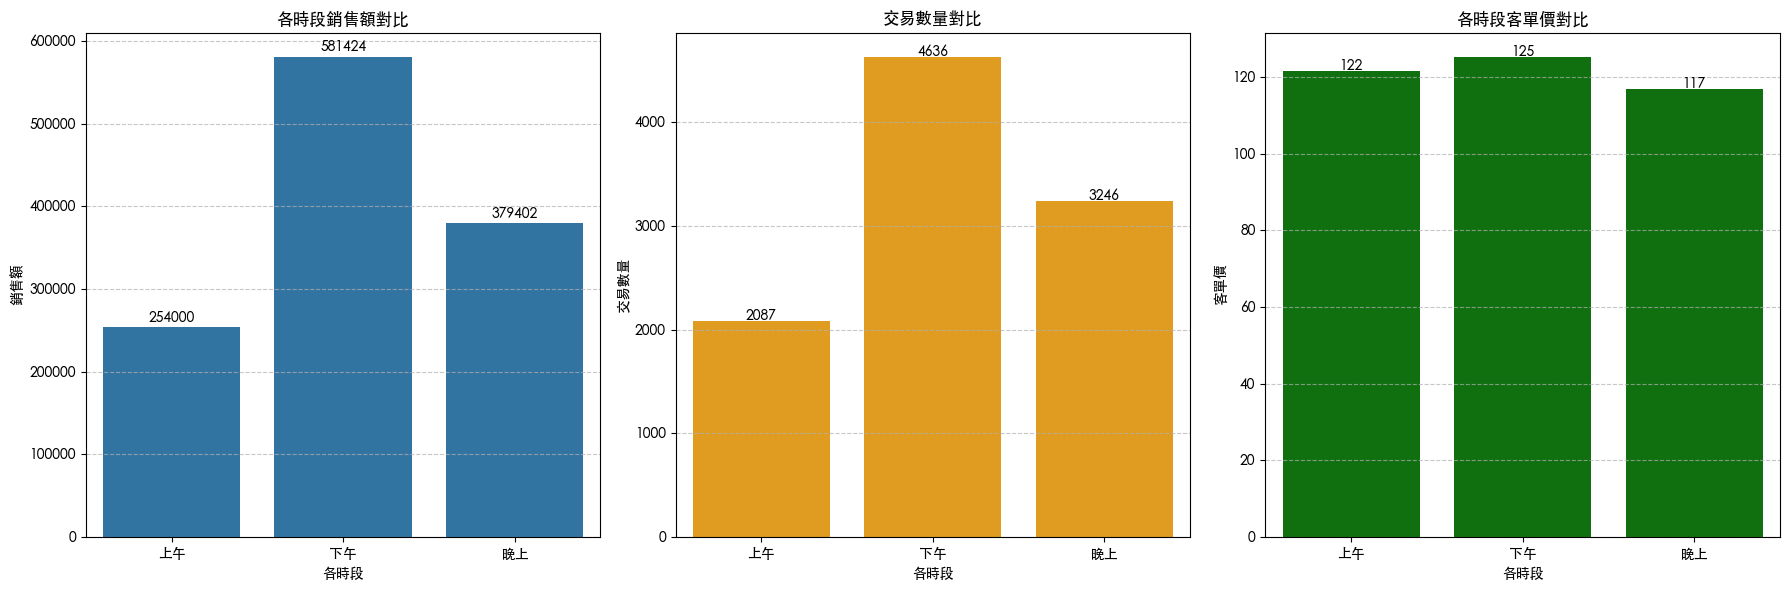

In [21]:
#銷售額計算＿按時段
period_sale=df.groupby("time_period").agg({
    "total":"sum","invoice_id":"nunique","quantity":"sum"}).reset_index()
period_sale["avg_sale"]=period_sale["total"]/period_sale["invoice_id"]
period_sale['avg_quantity'] =period_sale['quantity'] / period_sale['invoice_id']

#可視化圖表
plt.figure(figsize=(18, 6))
 #交易數量對比
plt.subplot(131)
sns.barplot(x="time_period",y="total",data=period_sale)
plt.title("各時段銷售額對比")
plt.xlabel("各時段")
plt.ylabel("銷售額")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(period_sale['total']):
    plt.text(i, v + 5000, f'{v:.0f}', ha='center')

    #客單價對比
plt.subplot(132)
sns.barplot(x="time_period",y="invoice_id",data=period_sale,color="orange")
plt.title("交易數量對比")
plt.xlabel("各時段")
plt.ylabel("交易數量")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(period_sale['invoice_id']):
    plt.text(i, v, f'{v:.0f}', ha='center')

    #週交易數對比
plt.subplot(133)
sns.barplot(x="time_period",y="avg_sale",data=period_sale,color="green")
plt.title("各時段客單價對比")
plt.xlabel("各時段")
plt.ylabel("客單價")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(period_sale['avg_sale']):
    plt.text(i, v , f'{v:.0f}', ha='center')
plt.tight_layout()
plt.savefig('各時段分析.png', dpi=300)


712

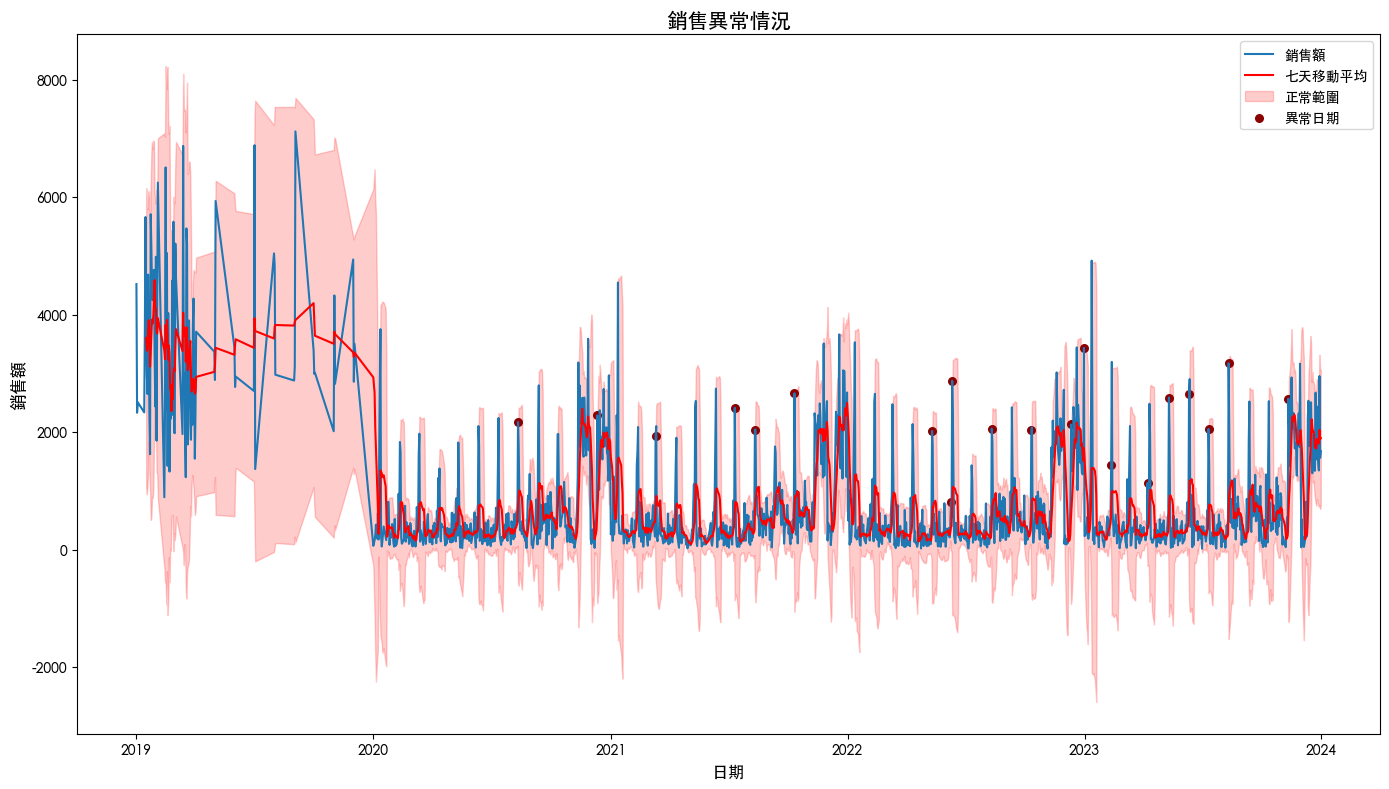

In [99]:
#篩選異常值
daily_sale = daily_sale.sort_index()
daily_sale['MA7']=daily_sale["total"].rolling(window=7).mean()
daily_sale['std7']=daily_sale["total"].rolling(window=7).std()


#測定上下值
daily_sale['upper_bound']=daily_sale['MA7']+2*daily_sale['std7']
daily_sale['lower_bound']=daily_sale['MA7']-2*daily_sale['std7']

#確認數值是否異常(前20異常點)
daily_sale["not_normal"]=(daily_sale["total"]>daily_sale['upper_bound'])|(daily_sale["total"]<daily_sale['lower_bound'])
daily_sale['score'] = ((daily_sale['total'] - daily_sale['MA7']).abs() / daily_sale['std7']
).round(2)
top_score = daily_sale.sort_values('score', ascending=False).head(20)


#可視化正常區間
plt.figure(figsize=(14,8))
plt.plot(daily_sale.index,daily_sale["total"],label='銷售額')
plt.plot(daily_sale.index,daily_sale["MA7"],label='七天移動平均',color="red")
plt.fill_between(daily_sale.index,daily_sale['upper_bound'],daily_sale['lower_bound'],alpha=0.2, color='red', label='正常範圍')
#標記異常點
plt.scatter(top_score.index,top_score["total"],color='darkred', label='異常日期', s=30)
plt.title('銷售異常情況', fontsize=15)
plt.xlabel('日期', fontsize=12)
plt.ylabel('銷售額', fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig('銷售異常情況.png', dpi=300)

#文字報告
top_score_sort=top_score.sort_values("date")
report=[]
report.append("前 20 個異常值文字報告\n")
for i ,row in top_score_sort.iterrows() :
    std_score=row["score"]
    direction  = "高於" if row['total'] > row['MA7'] else "低於"
    line=f"日期: {i.strftime('%Y-%m-%d')},銷售額:{row["total"]:.0f},{direction}七日均質{std_score}"
    report.append(line)

# 合併所有文字成一個長段落
report_text = "\n".join(report)

# 輸出成文字檔，加上 .txt 副檔名
Path("前20異常值文字報告.txt").write_text(report_text, encoding="utf-8-sig")
    







In [100]:
top_score_sort.head()


,total,MA7,std7,upper_bound,lower_bound,not_normal,score
date,,,,,,,
2020-08-11,2171.0,731.571429,651.015836,2033.603101,-570.460244,True,2.21
2020-12-11,2282.0,617.000000,765.768895,2148.537789,-914.537789,True,2.17
2021-03-11,1938.0,672.714286,582.504568,1837.723421,-492.294850,True,2.17
2021-07-11,2413.0,704.714286,784.959599,2274.633483,-865.204911,True,2.18
2021-08-11,2043.0,590.857143,663.664933,1918.187008,-736.472722,True,2.19
